In [29]:
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [4]:
#Create dataset to load the images

class LandscapeDataset(Dataset):
  def __init__(self, transform=None):
    self.dataroot = './images/landscape Images'
    self.images = os.listdir(f'{self.dataroot}/color')
    self.transform = transform

  def __len__(self):   #return the len of dataset
     return len(self.images)

  def __getitem__(self, idx):  #retrieve a specific img
     # Get image paths
     img_path = self.images[idx]

     # Load the images
     color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
     gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

     if self.transform:
       color_img = self.transform(color_img)
       gray_img = self.transform(gray_img)

     return color_img, gray_img

In [5]:
transform = transforms.Compose([transforms.Resize((150, 150), antialias=False)])

  #Load the dataset
dataset = LandscapeDataset(transform=transform)
  
  #Split the data into train and test data
train_set, test_set = random_split(dataset,[0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

  #Load the train and set data
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

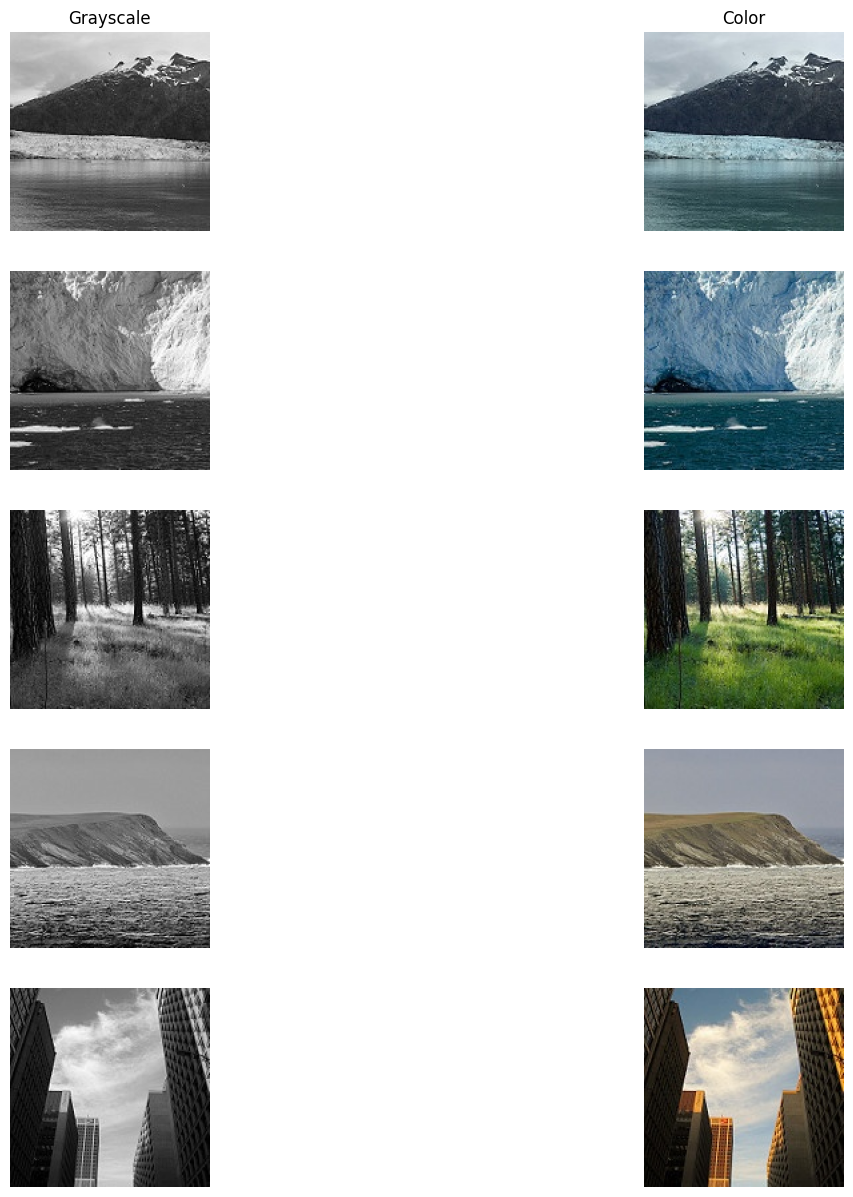

In [6]:
# Visualize some images
def show_image(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color') 
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0))
        axs[i, 1].axis('off')
    plt.show()

color, gray = next(iter(train_loader))
show_image(color, gray)
  

In [7]:
# Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, padding=1, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))

        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1, d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3, d1), dim=1)))

        return u4

In [9]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {total_params:,}')

Total number of trainable parameters: 3,470,659


In [10]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [51]:
# Define the training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(train_loader), total=len(train_loader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # MAke model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        #Calculate loss between colored image and model predictions
        loss = criterion(predictions, color_img)

        #Calculate gradients and backpropagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch+1}, Loss: {running_loss:.6f}')

  0%|          | 0/179 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 20 but got size 19 for tensor number 1 in the list.

In [12]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(test_loader), total=len(test_loader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        prediction = model(gray_img)

        # Calculate loss between colored image and model predictions
        loss = criterion(prediction, color_img)
        total_loss += loss.item()

    print(f'Total Test Loss: {total_loss/ len(test_loader):.3f}')

  0%|          | 0/45 [00:00<?, ?it/s]

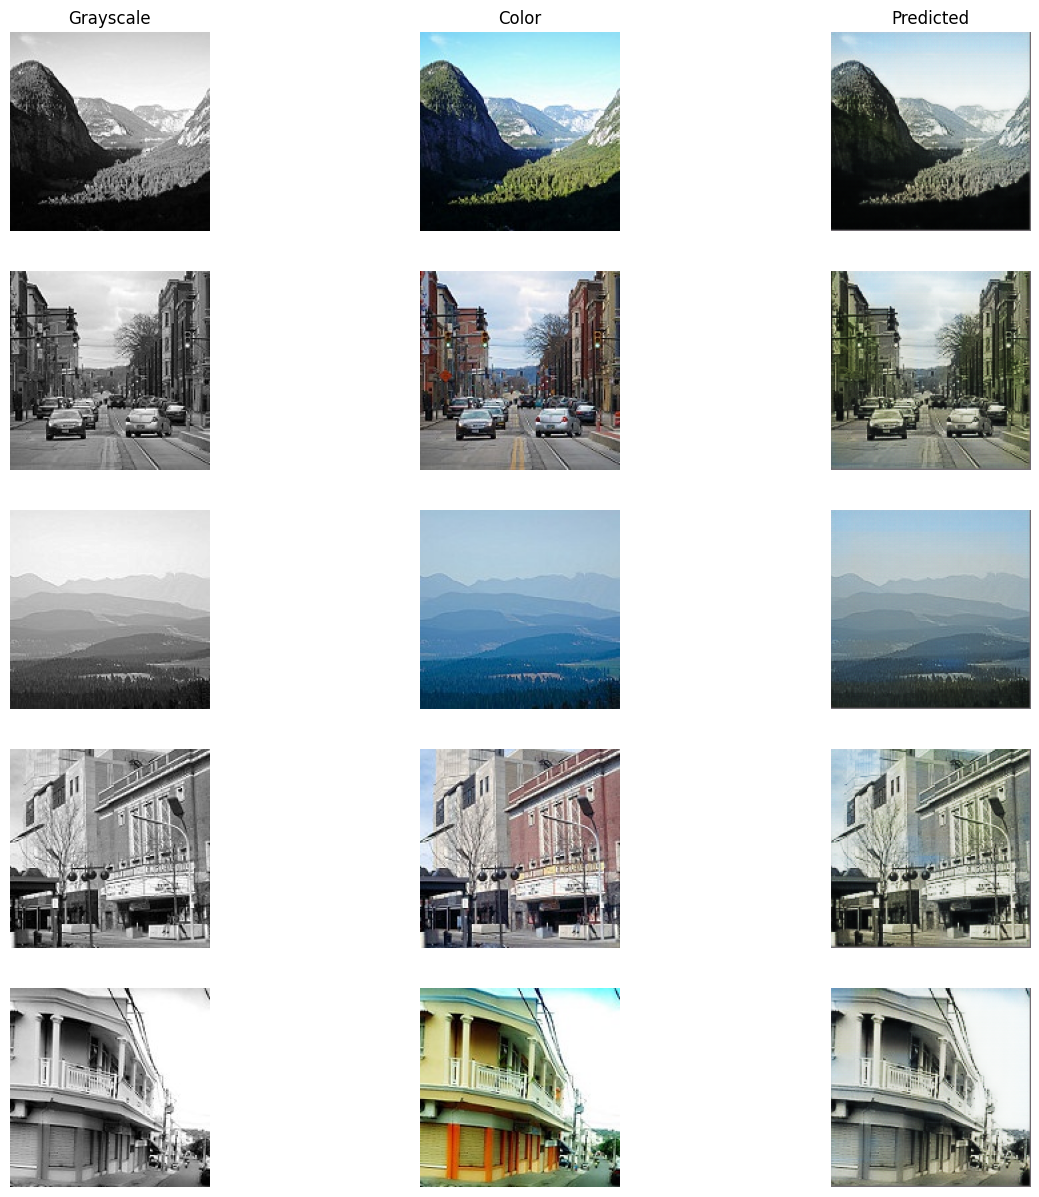

In [12]:
# Visualize some predictions

def show_predictions(color, gray, predictions):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')

    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(predictions[i].permute(1, 2, 0))
    plt.show()

show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())

In [47]:
# Assuming that `model` is your model
torch.save(model, 'model.pth')

In [50]:
model = ColorAutoEncoder()
model = model.to(DEVICE)

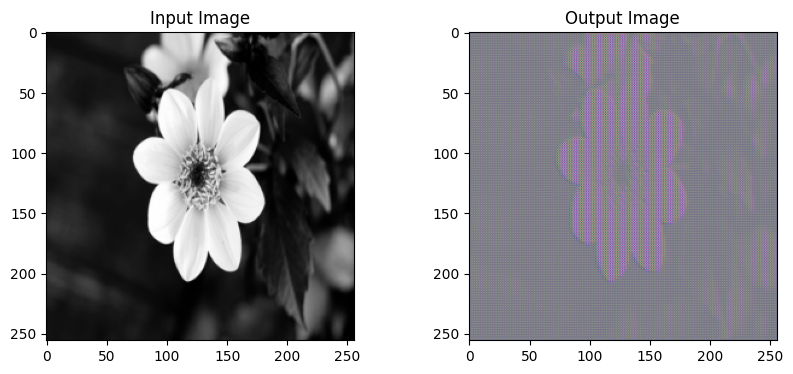

In [46]:
from PIL import Image
import torchvision.transforms as transforms

new_gray_img = Image.open('flower.jpg')

new_gray_img = new_gray_img.convert('L')


transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])


new_gray_img = transform(new_gray_img).unsqueeze(0)


new_gray_img = new_gray_img.to(DEVICE)


import matplotlib.pyplot as plt
import torch

import numpy as np

model.eval()

with torch.no_grad():
    output = model(new_gray_img)
    output_image = output.cpu().squeeze().numpy()


input_image = new_gray_img.cpu().squeeze().numpy()
output_image = np.transpose(output_image, (1, 2, 0))


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')


plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Output Image')

plt.show()

